# Домашнее задание № 10. Машинный перевод

## Задание 1 (6 баллов + 2 доп балла).
Нужно обучить трансформер на том же корпусе но в другую сторону - с русского на английский.
Можно использовать как основу первый или второй способ реализации (с MultiheadAttention или с nn.Transformer). Подберите несколько тестовых примеров для проверки обучения на каждой эпохе.

Параметры ниже точно работают в колабе и модель обучается достаточно быстро. Попробуйте их немного увеличить (batch size возможно придется наоборот уменьшить). Обучайте модель хотя бы 5 эпох, а желательно больше, чтобы тестовые примеры начали переводиться более менее адекватно.

После обучения возьмите хотя бы 100 примером из тестовой части параллельного корпуса и переведите их. Оцените качество переводов с помощью метрики BLEU (пример использования ниже)
Найдите лучшие (как минимум 5) переводы согласно этой метрике и проверьте действительно ли они хорошие. Если все переводы нулевые, то пообучайте модель подольше.

Чтобы получить 2 доп балла вам нужно будет придумать как оптимизировать функцию translate. Сейчас она работает только с одним текстом - это не эффективно. Можно генерировать переводы сразу для нескольких текстов (батча). Главная сложность с таким подходом состоит в том, что генерируемые тексты будут заканчиваться в разное время и нужно сделать столько итераций, сколько нужно для завершения всех текстов (т.е. условие на то, что последний токен не равен [EOS] в текущем коде не сработает).
ВАЖНО - недостаточно просто изменить входной аргумент с text на texts и добавить еще один цикл по texts! Сама модель должна вызываться на нескольких текстах! Функция с batch prediction должна работать быстрее, поэтому переведите всю тестовую выборку и оцените качество BLEU на всех данных.

In [1]:
# В колабе установите torchtune и torchao, чтобы семинарская тетрадка работала
!pip install torchtune torchao

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from collections import Counter

from torchtune.modules import RotaryPositionalEmbeddings
from torch.nn import Transformer
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.ru
!wget https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-test.en

--2025-03-31 05:12:58--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.ru
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121340806 (116M)
Saving to: ‘opus.en-ru-train.ru’

opus.en-ru-train.ru 100%[===================>] 115.72M  24.6MB/s    in 5.8s    

2025-03-31 05:13:05 (19.8 MB/s) - ‘opus.en-ru-train.ru’ saved [121340806/121340806]

--2025-03-31 05:13:05--  https://data.statmt.org/opus-100-corpus/v1.0/supervised/en-ru/opus.en-ru-train.en
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67760131 (65M)
Saving to: ‘opus.en-ru-train.en’

opus.en-ru-train.en 100%[===================>]  64.62M  18.7MB/s    in 3.6s    

2025-03-31 05:13:09 (17.8 MB/s) - ‘opus.en-ru

In [4]:
text = open('opus.en-ru-train.ru').read().replace('\xa0', ' ')
f = open('opus.en-ru-train.ru', 'w')
f.write(text)
f.close()

In [5]:
en_sents = open('opus.en-ru-train.en').read().splitlines()
ru_sents = open('opus.en-ru-train.ru').read().splitlines()

In [6]:
tokenizer_ru = Tokenizer(BPE())
tokenizer_ru.pre_tokenizer = Whitespace()

trainer_ru = BpeTrainer(special_tokens=["[PAD]"], end_of_word_suffix='</w>')
tokenizer_ru.train(files=["opus.en-ru-train.ru"], trainer=trainer_ru)

tokenizer_en = Tokenizer(BPE())
tokenizer_en.pre_tokenizer = Whitespace()

trainer_en = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')
tokenizer_en.train(files=["opus.en-ru-train.en"], trainer=trainer_en)

In [7]:
#!!
tokenizer_en.decoder = decoders.BPEDecoder()
tokenizer_ru.decoder = decoders.BPEDecoder()

In [8]:
tokenizer_en.save('tokenizer_en')
tokenizer_ru.save('tokenizer_ru')

In [9]:
tokenizer_en = Tokenizer.from_file("tokenizer_en")
tokenizer_ru = Tokenizer.from_file("tokenizer_ru")

In [10]:
def encode(text, tokenizer, max_len, encoder=False):
    if encoder:
        return tokenizer.encode(text).ids[:max_len]
    else:
        return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[EOS]')]

In [11]:
PAD_IDX = tokenizer_en.token_to_id('[PAD]')
PAD_IDX

0

In [12]:
max_len_en, max_len_ru = 47, 48

In [13]:
X_en = [encode(t, tokenizer_en, max_len_en) for t in en_sents]
X_ru = [encode(t, tokenizer_ru, max_len_ru, encoder=True) for t in ru_sents]

In [14]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, texts_ru, texts_en):
        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en, batch_first=True, padding_value=PAD_IDX)

        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru, batch_first=True, padding_value=PAD_IDX)

        self.length = len(texts_ru)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_en = self.texts_en[index]
        ids_ru = self.texts_ru[index]

        return ids_ru, ids_en

In [15]:
X_ru_train, X_ru_valid, X_en_train, X_en_valid, = train_test_split(X_ru, X_en, test_size=0.05)

In [16]:
class TransformerEncoderDecoder(nn.Module):
    def __init__(self, vocab_size_enc, vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.embedding_enc = nn.Embedding(vocab_size_enc, embed_dim)
        self.embedding_dec = nn.Embedding(vocab_size_dec, embed_dim)
        self.positional_encoding = RotaryPositionalEmbeddings(embed_dim // num_heads, max_seq_len=128)

        self.transformer = Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(embed_dim, vocab_size_dec)

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None):

        src_embedded = self.embedding_enc(src)
        B,S,E = src_embedded.shape
        src_embedded = self.positional_encoding(src_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)

        tgt_embedded = self.embedding_dec(tgt)
        B,S,E = tgt_embedded.shape
        tgt_embedded = self.positional_encoding(tgt_embedded.view(B,S,self.num_heads, E//self.num_heads)).view(B,S,E)


        tgt_mask = (~torch.tril(torch.ones((S, S), dtype=torch.bool))).to(DEVICE)

        encoder_output = self.transformer.encoder(
            src_embedded,
            src_key_padding_mask=src_key_padding_mask
        )

        decoder_output = self.transformer.decoder(
            tgt_embedded,
            encoder_output,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask
        )

        output = self.output_layer(decoder_output)
        return output

In [28]:
# попробуйте поставить параметры поменьше если в колабе обучается слишком долго!
vocab_size_enc = tokenizer_ru.get_vocab_size()
vocab_size_dec = tokenizer_en.get_vocab_size()

embed_dim = 36
num_heads = 6
ff_dim = embed_dim*2
num_layers = 4
batch_size = 200

model = TransformerEncoderDecoder(vocab_size_enc,vocab_size_dec, embed_dim, num_heads, ff_dim, num_layers)

In [29]:
training_set = Dataset(X_ru_train, X_en_train)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, )

valid_set = Dataset(X_ru_valid, X_en_valid)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [26]:
from time import time
def train(model, iterator, optimizer, criterion, scheduler, run=None, print_every=100):

    epoch_loss = []
    ac = []

    model.train()

    for i, (texts_ru, texts_en) in enumerate(iterator):
        texts_en = texts_en.to(DEVICE)
        texts_ru = texts_ru.to(DEVICE)
        texts_en_input = texts_en[:,:-1].to(DEVICE)
        texts_en_out = texts_en[:, 1:].to(DEVICE)
        src_padding_mask = (texts_ru == PAD_IDX).to(DEVICE)
        tgt_padding_mask = (texts_en_input == PAD_IDX).to(DEVICE)
        logits = model(texts_ru, texts_en_input, src_padding_mask, tgt_padding_mask)
        optimizer.zero_grad()
        B,S,C = logits.shape
        loss = loss_fn(logits.reshape(B*S, C), texts_en_out.reshape(B*S))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)};')
        if run is not None:
            run.log({"loss": loss.item()})

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion, run=None):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for i, (texts_ru, texts_en) in enumerate(iterator):
            texts_en = texts_en.to(DEVICE)
            texts_ru = texts_ru.to(DEVICE)
            texts_en_input = texts_en[:,:-1].to(DEVICE)
            texts_en_out = texts_en[:, 1:].to(DEVICE)
            src_padding_mask = (texts_ru == PAD_IDX).to(DEVICE)
            tgt_padding_mask = (texts_en_input == PAD_IDX).to(DEVICE)

            logits = model(texts_ru, texts_en_input, src_padding_mask, tgt_padding_mask)

            B,S,C = logits.shape
            loss = loss_fn(logits.reshape(B*S, C), texts_en_out.reshape(B*S))
            epoch_loss.append(loss.item())
            if run is not None:
                run.log({"val_loss": loss.item()})

    return np.mean(epoch_loss)

In [20]:
@torch.no_grad
def translate(text):


    input_ids = tokenizer_ru.encode(text).ids[:max_len_ru]
    output_ids = [tokenizer_en.token_to_id('[BOS]')]

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)], batch_first=True).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)

    src_padding_mask = (input_ids_pad == PAD_IDX).to(DEVICE)
    tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

    logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)

    pred = logits.argmax(2).item()

    while pred not in [tokenizer_en.token_to_id('[EOS]'), tokenizer_en.token_to_id('[PAD]')] and len(output_ids) < 100:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)], batch_first=True).to(DEVICE)
        tgt_padding_mask = (output_ids_pad == PAD_IDX).to(DEVICE)

        logits = model(input_ids_pad, output_ids_pad, src_padding_mask, tgt_padding_mask)
        pred = logits.argmax(2).view(-1)[-1].item()

    return tokenizer_en.decoder.decode([tokenizer_en.id_to_token(i) for i in output_ids[1:]])

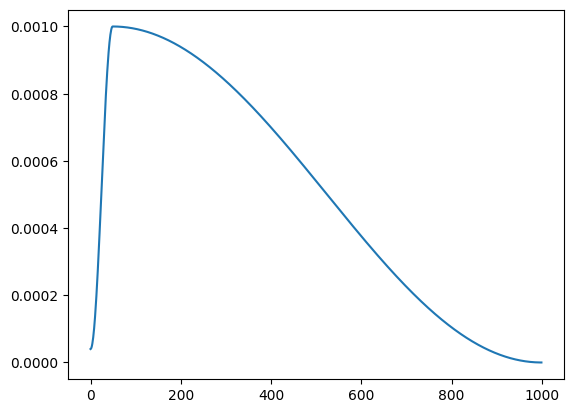

In [30]:
fake_model = torch.nn.Linear(2, 1)
fake_optimizer = torch.optim.AdamW(fake_model.parameters(), lr=0.0001)
fake_scheduler = torch.optim.lr_scheduler.OneCycleLR(fake_optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=50, epochs=20)
lrs = []

for i in range(1000):
    fake_optimizer.step()
    lrs.append(fake_optimizer.param_groups[0]["lr"])
    fake_scheduler.step()

plt.plot(lrs)

In [31]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
model = model.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, pct_start=0.05,
                                                steps_per_epoch=len(training_generator), epochs=5)

In [33]:
from timeit import default_timer as timer
NUM_EPOCHS = 5

losses = []
run = None

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(model, training_generator, optimizer, loss_fn, scheduler, run)
    end_time = timer()
    val_loss = evaluate(model, valid_generator, loss_fn, run)

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(model, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(model, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

    print(translate("Это пример"))
    print(translate('Ты можешь это перевести?'))
    print(translate('Что ты собираешься с этим делать?'))
    print(translate('Жизнь прекрасна'))

Loss: 10.27358736038208;
Loss: 10.115881233215331;
Loss: 9.898197189966838;
Loss: 9.584483551979066;
Loss: 9.186367567062378;
Loss: 8.81345179160436;
Loss: 8.515476082393102;
Loss: 8.269112652540207;
Loss: 8.056223652627732;
Loss: 7.872862775802612;
Loss: 7.711205448237332;
Loss: 7.566784700155258;
Loss: 7.437860993972191;
Loss: 7.3228903497968405;
Loss: 7.217647878646851;
Loss: 7.121555885076523;
Loss: 7.036190709226272;
Loss: 6.957503888871934;
Loss: 6.88446586257533;
Loss: 6.816735849142074;
Loss: 6.753394083295549;
Loss: 6.693670038960197;
Loss: 6.638633356923642;
Loss: 6.587284903128942;
Loss: 6.539159935379028;
Loss: 6.493973179046924;
Loss: 6.4504225552523575;
Loss: 6.409169994422368;
Loss: 6.370332542123466;
Loss: 6.332695086956024;
Loss: 6.297770671229209;
Loss: 6.264064729064703;
Loss: 6.231535665483186;
Loss: 6.200319779620451;
Loss: 6.170404753548758;
Loss: 6.141634365055296;
Loss: 6.114014082599331;
Loss: 6.08771583343807;
Loss: 6.0616450709563034;
Loss: 6.036793909430504;

BLEU

In [39]:
data_hypothesis = ru_sents[:150]
data_reference = en_sents[:150]

In [40]:
hypotheses = []
for data in data_hypothesis:
  hypotheses.append(translate(data))

In [47]:
import nltk
BLEUscores = {}
for i, hypothesis in enumerate(hypotheses):
  reference = data_reference[i].split()
  hypothesis_split = hypothesis.split()
  ref_hyp = (data_reference[i], hypothesis)
  BLEUscores[ref_hyp] = (nltk.translate.bleu_score.sentence_bleu([reference], hypothesis_split, auto_reweigh=True))

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [50]:
top_5 = sorted(BLEUscores.items(), key=lambda item: item[1], reverse=True)[:5]

In [54]:
top_5

[(('!', '!'), 1.0),
 (('I need to talk to him.', 'I need to talk to him .'), 0.6147881529512643),
 (('The time now is 11:38 AM .', 'The time now is 04 : 00 AM .'),
  0.3549481056010053),
 (('The time now is 02:25 PM .', 'The time now is 04 : 30 AM .'),
  0.3155984539112945),
 (("It encourages the State party to make full use of the Committee's general recommendation 19 in such efforts and of the United Nations Secretary-General's in-depth study on all forms of violence against women (A/61/122/Add.1 and Corr.1).",
   'He urges the State party to ensure that the Secretary - General on the United Nations system and the United Nations system of the United Nations system , including the United Nations system of the United Nations system ( A / CN .'),
  0.12273033502938982)]


## Задание 2 (2 балла).
Прочитайте главу про машинный перевод у Журафски и Маннига - https://web.stanford.edu/~jurafsky/slp3/13.pdf
Ответьте своими словами в чем заключается техника back translation? Для чего она применяется и что позволяет получить? Опишите по шагам как ее применить к паре en->ru на данных из семинара. Сколько моделей понадобится? Сколько запусков обучения нужно будет сделать?

Ответ должен содержать как минимум 10 предложений.

back translation - техника аугментации данных для машинного перевода. Она используется, когда у одного из двух языков участвующих в переводе больший объем данных, чем у другого.

Для начала тренируется обратная модель, то есть если нам надо обучить en->ru, сначала мы обучаем ru->en. Эта обратная модель используется для перевода текстов на нашем target языке на язык source. То есть мы переводим русские тексты на английский и присоединяем эти синтетические тексты к трейн выборке. Затем мы переобучаем нашу модель уже в нужном направлении en->ru.

back translation можно осуществлять разными способами ввиду разнообразия параметров. В частности, это разнообразие относится к тому, как мы генерируем "обратные" данные для промежуточной модели. Мы можем использовать "жадный" инференс, beam search, temperature sampling или upsampling.

Таким образом нам понадобятся 2 модели и 2 запуска обучения.

